In [1]:
import numpy as np
import scipy
import scipy.io

In [2]:
sax_rate, sax = scipy.io.wavfile.read('sax.wav')
mix_rate, mix = scipy.io.wavfile.read('mix.wav')

In [3]:
mono_sax = np.empty((250000),np.float32)
mono_mix = np.empty((250000),np.float32)
for i in range(mono_sax.size):
    mono_sax[i] = round((sax[i][0]+sax[i][1])/2)
    mono_mix[i] = mix[i]
del sax
del mix

In [4]:
class My_Scaler:
    def __init__(self, min, max, a, b):
        self.a = a
        self.b = b
        self.min = min
        self.max = max

    def transform(self, input):
        return ((self.b-self.a)*((input-self.min)/(self.max-self.min)))+self.a

    def inverse_transform(self,input):
        return ((self.max - self.min)*((input+self.b)/(self.b-self.a))+self.min)

In [5]:
min = mono_mix.min()
if mono_sax.min() < min:
    min = mono_sax.min()
max = mono_mix.max()
if mono_sax.max() > max:
    max = mono_sax.max()
scaler = My_Scaler(min,max,-1,1)

In [6]:
x = scaler.transform(mono_mix)
y = scaler.transform(mono_sax)

In [7]:
encoding = 128
seq_len = 128

In [8]:
data = np.empty([250000,2],np.float32)

for i in range(data.shape[0]):
    data[i][0] = x[i]
    data[i][1] = y[i]

In [9]:
import torch
from torchaudio.functional import mu_law_encoding, mu_law_decoding
data=mu_law_encoding(torch.from_numpy(data),encoding)

In [11]:
class TimesereisDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_len=128):
        super().__init__()
        self.data=data
        self.seq_len=seq_len

    def __len__(self):
        return 250000-(self.seq_len)

    def __getitem__(self,index):
        x=self.data[index:index+self.seq_len,0]
        y=self.data[index+self.seq_len,1]
        return x,y

In [12]:
data = data.numpy()

In [13]:
one_hot_data = []
for i in range(data.shape[0]):
    x_hot = np.zeros(encoding)
    y_hot = np.zeros(encoding)
    x_hot[data[i][0]] = 1.0
    y_hot[data[i][1]] = 1.0
    one_hot_data.append((x_hot,y_hot))
one_hot_data = np.array(one_hot_data)

In [14]:
timeSeriesDataset = TimesereisDataset(one_hot_data,seq_len)

In [15]:
train = []
test=[]
for i in range(int(round(len(timeSeriesDataset)/2))):
    if i%10 < 8:
        train.append(timeSeriesDataset[i])
    else: test.append(timeSeriesDataset[i])
del mono_sax
del mono_mix

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam

In [17]:
batch = 256

model=Sequential()
model.add(LSTM(seq_len,batch_input_shape=(batch,seq_len,encoding)))
model.add(Dropout(0.2))
model.add(Dense(encoding,activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(encoding,activation='softmax'))

In [18]:
optimizer = Adam(learning_rate=0.0015)

In [19]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [20]:

xtrain = []
ytrain = []
for x,y in train:
    xtrain.append(x)
    ytrain.append(y)
xval = []
yval = []
for x,y in test:
    xval.append(x)
    yval.append(y)
del train
del test
xtrain = np.array(xtrain)
ytrain = np.array(ytrain)
xval = np.array(xval)
yval = np.array(yval)

In [20]:
history = model.fit(xtrain,ytrain, epochs=150, batch_size=batch, validation_data=(xval, yval))

Epoch 1/150


391/391 [==============================] - 70s 172ms/step - loss: 4.0335 - accuracy: 0.1115 - val_loss: 3.6364 - val_accuracy: 0.1274
Epoch 2/150
391/391 [==============================] - 62s 159ms/step - loss: 3.5021 - accuracy: 0.1427 - val_loss: 3.3276 - val_accuracy: 0.1598
Epoch 3/150
391/391 [==============================] - 62s 159ms/step - loss: 3.2361 - accuracy: 0.1649 - val_loss: 3.4868 - val_accuracy: 0.1638
Epoch 4/150
391/391 [==============================] - 62s 159ms/step - loss: 3.1957 - accuracy: 0.1737 - val_loss: 2.9039 - val_accuracy: 0.1962
Epoch 5/150
391/391 [==============================] - 62s 159ms/step - loss: 2.8274 - accuracy: 0.2065 - val_loss: 2.6679 - val_accuracy: 0.2183
Epoch 6/150
391/391 [==============================] - 62s 159ms/step - loss: 2.6148 - accuracy: 0.2279 - val_loss: 2.5329 - val_accuracy: 0.2288
Epoch 7/150
391/391 [==============================] - 62s 160ms/step - loss: 2.5064 - accuracy: 0.2413 - val_loss: 2.4632

In [21]:
print(history.history)

{'loss': [4.0334696769714355, 3.502079486846924, 3.2361154556274414, 3.195666551589966, 2.827388048171997, 2.6147663593292236, 2.506389856338501, 2.368381977081299, 2.304142951965332, 2.2143657207489014, 2.145925521850586, 2.0889832973480225, 2.023216962814331, 1.9890762567520142, 2.036853551864624, 2.047992706298828, 1.9384170770645142, 1.8580551147460938, 1.811912178993225, 1.7855795621871948, 1.7500234842300415, 1.7275506258010864, 1.6943705081939697, 1.6781020164489746, 1.6365121603012085, 1.6225569248199463, 1.5916095972061157, 1.5736883878707886, 1.561635971069336, 1.5344434976577759, 1.513034462928772, 1.4878169298171997, 1.4890754222869873, 1.4622009992599487, 1.4590260982513428, 1.4435185194015503, 1.4399901628494263, 1.4123767614364624, 1.3877185583114624, 1.3865402936935425, 1.3782811164855957, 1.3832131624221802, 1.3536350727081299, 1.3317664861679077, 1.3463733196258545, 1.329154372215271, 1.3290979862213135, 1.3003442287445068, 1.2966686487197876, 1.2919316291809082, 1.29

<Axes: >

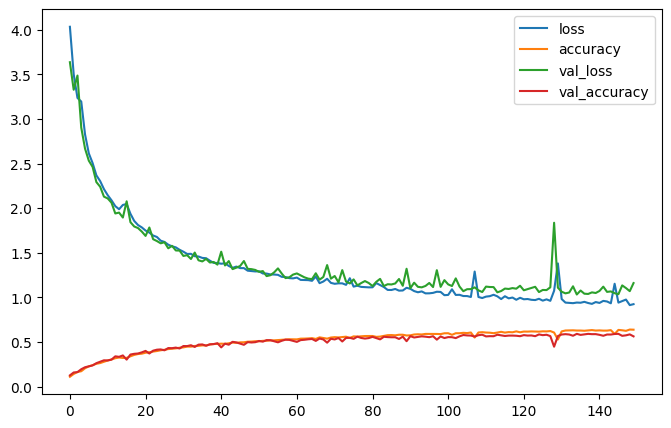

In [22]:
import matplotlib as plt
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))

In [21]:
del xtrain
del ytrain
del xval
del yval

In [23]:
model.save('D:\\Documents\\CPE590\\project\\tf_lstm\\model.keras')

In [22]:
model = tf.keras.models.load_model('D:\\Documents\\CPE590\\project\\tf_lstm\\model.keras')

In [23]:
from tensorflow.math import argmax

In [25]:
cleaned = []

In [26]:
test_data = []
for i in range(len(timeSeriesDataset)):
    noised, baseline = timeSeriesDataset[i]
    test_data.append(noised)
test_data = np.array(test_data)

In [27]:
out = model.predict(test_data)

7809/7809 [==============================] - 127s 16ms/step


In [28]:
del test_data

In [31]:
for i in range(len(out)):
    cleaned.append(argmax(out[i]).numpy())

In [33]:
cleaned_mu = np.zeros(len(cleaned),dtype=np.float32)
for i in range(len(cleaned)):
    cleaned_mu[i] = cleaned[i]

In [34]:
del cleaned

In [35]:
cleaned_mu = mu_law_decoding(torch.from_numpy(cleaned_mu),encoding)

In [36]:
cleaned_mu = cleaned_mu.numpy()

In [38]:
scaled = []
for i in range(len(cleaned_mu)):
  scaled.append(scaler.inverse_transform(cleaned_mu[i]))

The predicted, decoded, and scaled output 

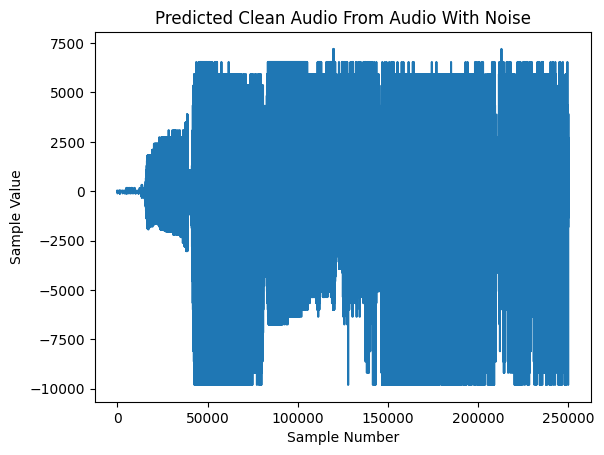

In [40]:
import matplotlib.pyplot as plt
plt.plot(scaled)
plt.title("Predicted Clean Audio From Audio With Noise")
plt.xlabel("Sample Number")
plt.ylabel("Sample Value")
plt.show()

Target output 

In [42]:
scaled = np.array(scaled, dtype=np.int16)
scipy.io.wavfile.write('predicted.wav',44100,scaled)